In [1]:
import copy

In [2]:
from gym_electric_motor import reward_functions
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt


In [4]:
from drmdp import feats
from drmdp.envs import gem

In [5]:
rf = gem.PositiveEnforcementWeightedSumOfErrors(penalty_gamma=1.0)

In [6]:
env = gem.make("Finite-CC-PMSM-v0", reward_fn="default", max_episode_steps=1000)
env

<TimeLimit<GemObsAsVectorWrapper<FiniteCurrentControlPermanentMagnetSynchronousMotorEnv<Finite-CC-PMSM-v0>>>>

In [7]:
def get_sample(size: int):
    starting_states = []
    for _ in range(size):
        obs, _ = env.reset()
        starting_states.append(obs)
    return np.stack(starting_states)

In [8]:
starting_states = get_sample(10_000)

In [9]:
starting_states.shape

(10000, 4)

In [10]:
df_so = pd.DataFrame({str(col): starting_states[:,col] for col in range(starting_states.shape[1]) })

In [11]:
df_so

,0,1,2,3
0,0.144486,0.022530,0.0,1.0
1,0.144486,0.022530,0.0,1.0
2,0.246514,0.094789,0.0,1.0
3,0.145841,0.001600,0.0,1.0
4,0.066364,0.288774,0.0,1.0
...,...,...,...,...
9995,0.050783,0.287778,0.0,1.0
9996,0.098347,0.169832,0.0,1.0
9997,0.249554,0.000183,0.0,1.0
9998,0.158591,0.150480,0.0,1.0


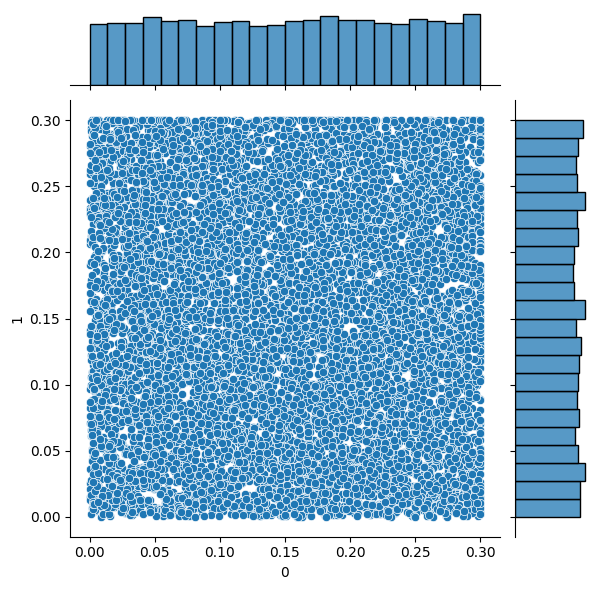

In [12]:
sns.jointplot(data=df_so, x="0", y="1")

In [13]:
env.observation_space.low, env.observation_space.high

(array([0., 0., 0., 0.]), array([0.8, 0.8, 1. , 1. ]))

In [14]:
def play(env, num_episodes: int, feat_transform):
    init_obs = []
    returns = []
    for i in range(num_episodes):
        obs, _ = env.reset()
        init_obs.append(obs)
        rewards = 0
        while True:
            action = env.action_space.sample()
            (
                next_obs,
                reward,
                term,
                trunc,
                _,
            ) = env.step(action)
            rewards += reward
            obs = next_obs
            if term or trunc:
                returns.append(rewards)
                break
    return init_obs, returns

In [15]:
def collect_return_sample(env, size: int):
    feat_transform = feats.create_feat_transformer(env, **{"name": "scale", "args": None})
    init_obs, returns = play(env, num_episodes=size, feat_transform=feat_transform)
    return init_obs, returns

In [16]:
collect_return_sample(env, size=10)

([array([0.22644954, 0.15171159, 0.        , 1.        ]),
  array([0.15955118, 0.05341473, 0.        , 1.        ]),
  array([0.17543042, 0.03752798, 0.        , 1.        ]),
  array([0.13775111, 0.07435723, 0.        , 1.        ]),
  array([0.15287517, 0.28440221, 0.        , 1.        ]),
  array([0.13874392, 0.02206417, 0.        , 1.        ]),
  array([0.21845366, 0.07075664, 0.        , 1.        ]),
  array([0.05704959, 0.28901885, 0.        , 1.        ]),
  array([0.26744244, 0.15665679, 0.        , 1.        ]),
  array([0.01446034, 0.21047122, 0.        , 1.        ])],
 [-130.55608125177258,
  -230.8846193217295,
  -120.05499824345992,
  -117.10722069409124,
  -165.32448645773889,
  -247.94027560481777,
  -108.46322635178284,
  -270.95066087291303,
  -171.94137305466452,
  -138.07870392100727])

## Reward Patterns

In [17]:
MAX_STEPS = 1000

In [18]:
def collect_reward_sample(reward_fn, size: int):
    env = gem.make("Finite-CC-PMSM-v0", reward_fn=reward_fn, max_episode_steps=MAX_STEPS)
    obs, _ = env.reset()
    logs = []
    num_steps = 0
    while num_steps < size:
        action = env.action_space.sample()
        next_obs, reward, term, trunc, _ = env.step(
            action
        )
        logs.append((copy.copy(obs), action, copy.copy(next_obs), reward))
        obs = next_obs
        done = term or trunc
        num_steps += 1

        if (num_steps + 1) % (size // 5) == 0:
            print("Step", num_steps + 1)

        if done:
            obs, _ = env.reset()
    env.close()
    return logs

In [19]:
default_rew_logs = collect_reward_sample(reward_fn="default", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [20]:
default_rew_logs[:5]

[(array([0.23829285, 0.11056472, 0.        , 1.        ]),
  5,
  array([0.24300813, 0.10783058, 0.        , 1.        ]),
  -0.1754193588485216),
 (array([0.24300813, 0.10783058, 0.        , 1.        ]),
  3,
  array([0.2522272 , 0.11554451, 0.        , 1.        ]),
  -0.18388585267668608),
 (array([0.2522272 , 0.11554451, 0.        , 1.        ]),
  6,
  array([0.26960718, 0.10528194, 0.        , 1.        ]),
  -0.1874445620641993),
 (array([0.26960718, 0.10528194, 0.        , 1.        ]),
  7,
  array([0.27578122, 0.10159548, 0.        , 1.        ]),
  -0.18868834941981094),
 (array([0.27578122, 0.10159548, 0.        , 1.        ]),
  4,
  array([0.27872785, 0.10614161, 0.        , 1.        ]),
  -0.1924347320202868)]

In [21]:
pos_rew_logs = collect_reward_sample(reward_fn="pos-enf", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [22]:
pos_rew_logs[:5]

[(array([0.17350032, 0.2347219 , 0.        , 1.        ]),
  3,
  array([0.16404217, 0.23452004, 0.        , 1.        ]),
  1.8007188954896627),
 (array([0.16404217, 0.23452004, 0.        , 1.        ]),
  5,
  array([0.16234636, 0.23022353, 0.        , 1.        ]),
  1.8037150555011707),
 (array([0.16234636, 0.23022353, 0.        , 1.        ]),
  7,
  array([0.16219155, 0.22976463, 0.        , 1.        ]),
  1.8040219070182353),
 (array([0.16219155, 0.22976463, 0.        , 1.        ]),
  7,
  array([0.16123312, 0.2295666 , 0.        , 1.        ]),
  1.8046001416846926),
 (array([0.16123312, 0.2295666 , 0.        , 1.        ]),
  2,
  array([0.14820305, 0.23240618, 0.        , 1.        ]),
  1.809695385744428)]

In [23]:
highpenalty_rew_logs = collect_reward_sample(reward_fn="esp-neg", size=10_000)

Step 2000
Step 4000
Step 6000
Step 8000
Step 10000


In [24]:
highpenalty_rew_logs[:5]

[(array([0.16463223, 0.16765227, 0.        , 1.        ]),
  4,
  array([0.17408837, 0.16744166, 0.        , 1.        ]),
  -0.17076501689470155),
 (array([0.17408837, 0.16744166, 0.        , 1.        ]),
  7,
  array([0.17410613, 0.16497034, 0.        , 1.        ]),
  -0.16953823302574828),
 (array([0.17410613, 0.16497034, 0.        , 1.        ]),
  7,
  array([0.17311667, 0.16178701, 0.        , 1.        ]),
  -0.167451840308036),
 (array([0.17311667, 0.16178701, 0.        , 1.        ]),
  5,
  array([0.17976504, 0.16332348, 0.        , 1.        ]),
  -0.17154426137615442),
 (array([0.17976504, 0.16332348, 0.        , 1.        ]),
  6,
  array([0.18578989, 0.17176088, 0.        , 1.        ]),
  -0.17877538482044344)]

In [25]:
def logs_as_dataframe(rew_logs, tag):
    obs, actions, next_obs, rewards = zip(*rew_logs)
    df_rw_logs = pd.DataFrame(
        {
            "obs": obs,
            "action": actions,
            "next_obs": next_obs,
            "reward": rewards
        }
    )
    df_rw_logs["fn"] = tag
    return df_rw_logs

In [26]:
df_obs_rew = pd.concat([
    logs_as_dataframe(default_rew_logs, tag="default"),
    logs_as_dataframe(pos_rew_logs, tag="pos-enf"),
    logs_as_dataframe(highpenalty_rew_logs, tag="esp-neg"),
])

In [27]:
df_obs_rew

,obs,action,next_obs,reward,fn
0,"[0.23829284995618463, 0.11056471960212425, 0.0...",5,"[0.2430081335579487, 0.10783058413909449, 0.0,...",-0.175419,default
1,"[0.2430081335579487, 0.10783058413909449, 0.0,...",3,"[0.2522271976693607, 0.11554450768401146, 0.0,...",-0.183886,default
2,"[0.2522271976693607, 0.11554450768401146, 0.0,...",6,"[0.2696071819670509, 0.10528194216134769, 0.0,...",-0.187445,default
3,"[0.2696071819670509, 0.10528194216134769, 0.0,...",7,"[0.27578121925578913, 0.10159547958383272, 0.0...",-0.188688,default
4,"[0.27578121925578913, 0.10159547958383272, 0.0...",4,"[0.27872785235490893, 0.10614161168566465, 0.0...",-0.192435,default
...,...,...,...,...,...
9995,"[0.07754401782100599, 0.08304906469629894, 0.0...",7,"[0.0777658405295835, 0.08649020288825998, 0.0,...",-0.082128,esp-neg
9996,"[0.0777658405295835, 0.08649020288825998, 0.0,...",2,"[0.07493857268770884, 0.03134927117454581, 0.0...",-0.053144,esp-neg
9997,"[0.07493857268770884, 0.03134927117454581, 0.0...",5,"[0.07880322600725752, 0.050813425857066774, 0....",-0.064808,esp-neg
9998,"[0.07880322600725752, 0.050813425857066774, 0....",0,"[0.07891839243496654, 0.10290875057113143, 0.0...",-0.090914,esp-neg


## State ~ Reward

In [28]:
def plot_rewards(df, state_idx):
    # remove extremes for pos
    df_plot = copy.deepcopy(df)
    df_plot = df_plot[np.abs(df["reward"].values) < (2**30 - 1)]
    actions = tuple(sorted(df_plot["action"].unique()))
    fig, axes = plt.subplots(ncols=len(actions), figsize=(4*len(actions), 4))
    for action, ax in zip(actions, axes.flatten()):
        df_subplot = df_plot[df_plot["action"] == action]
        df_subplot = copy.deepcopy(df_subplot[["obs", "reward", "fn"]])
        df_subplot["obs"] = df_subplot["obs"].apply(lambda xs: xs[state_idx])
        sns.scatterplot(data=df_subplot, x="obs", y="reward", hue="fn", ax=ax)
        ax.set_title(f"$S[{state_idx}]$, Action: {action}")

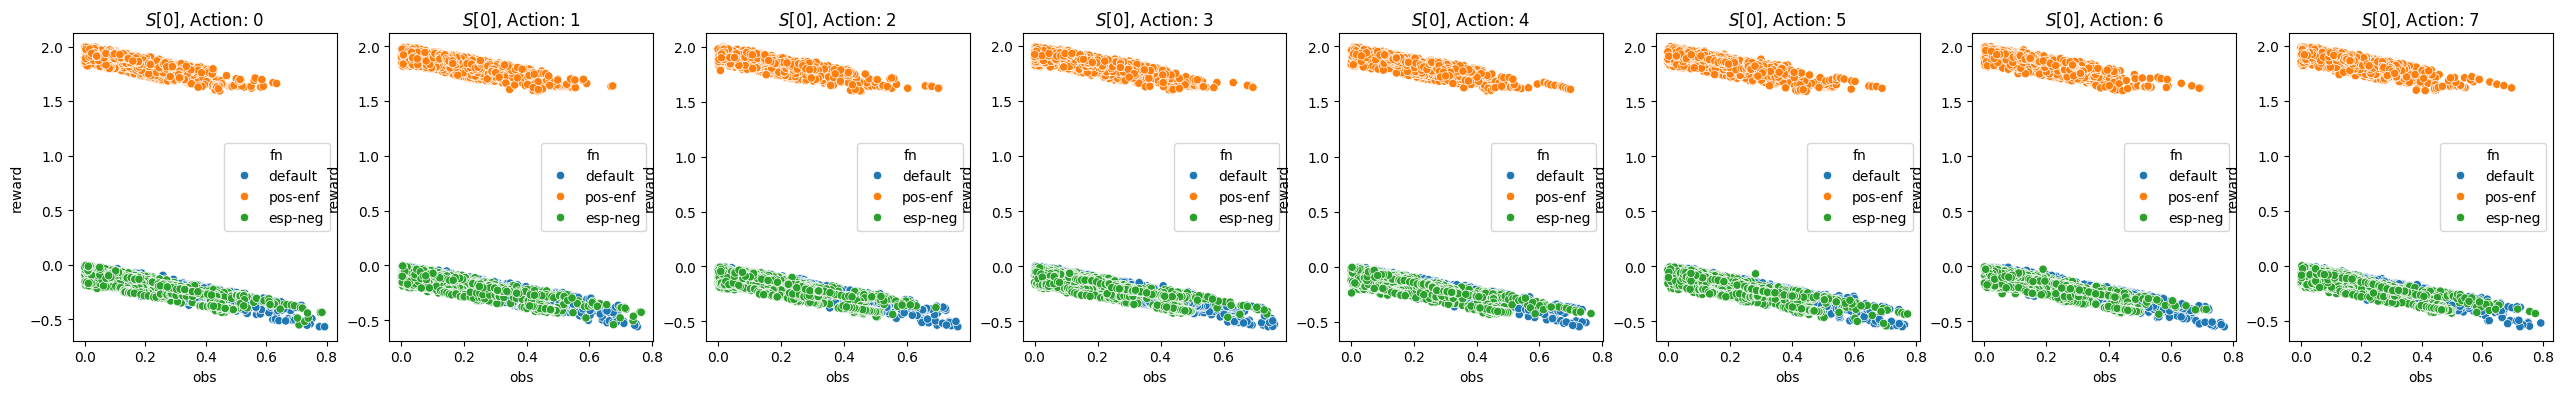

In [29]:
plot_rewards(df_obs_rew, state_idx=0)

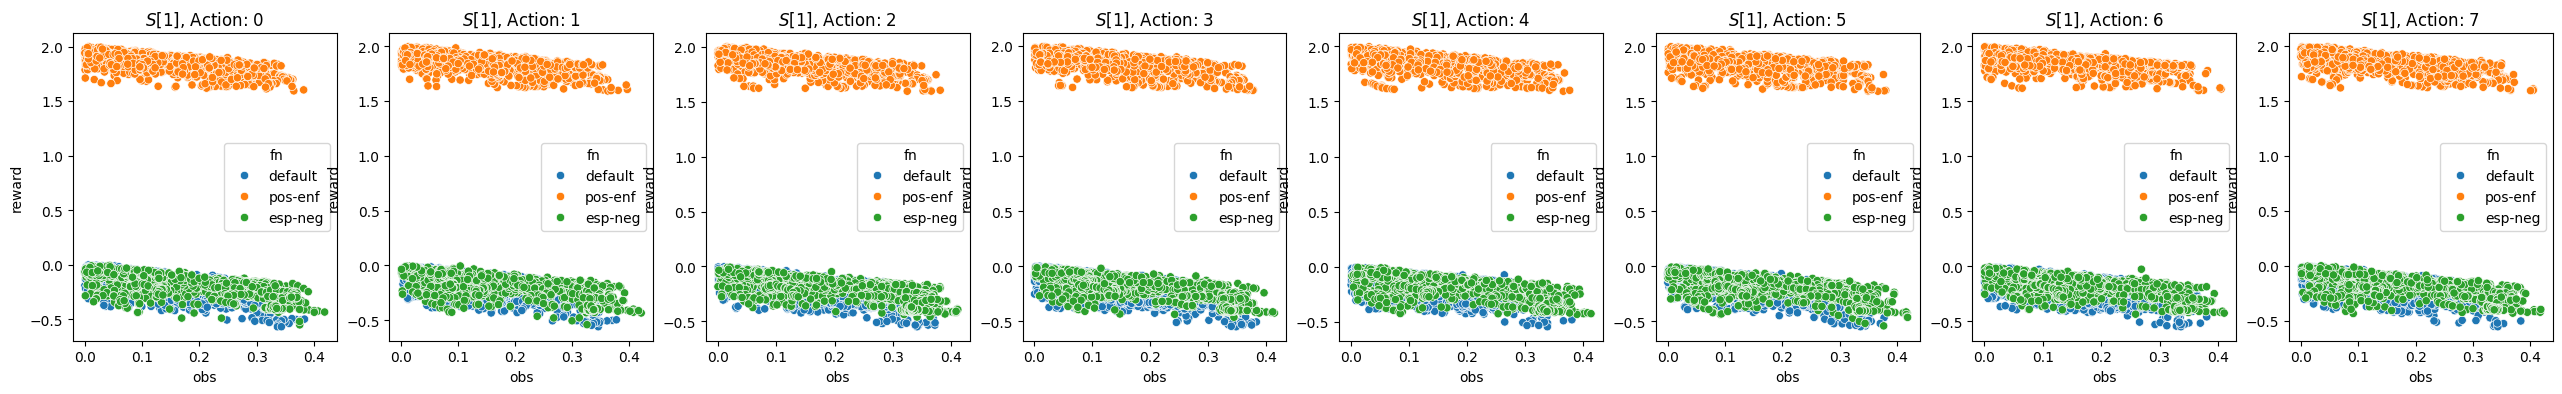

In [30]:
plot_rewards(df_obs_rew, state_idx=1)

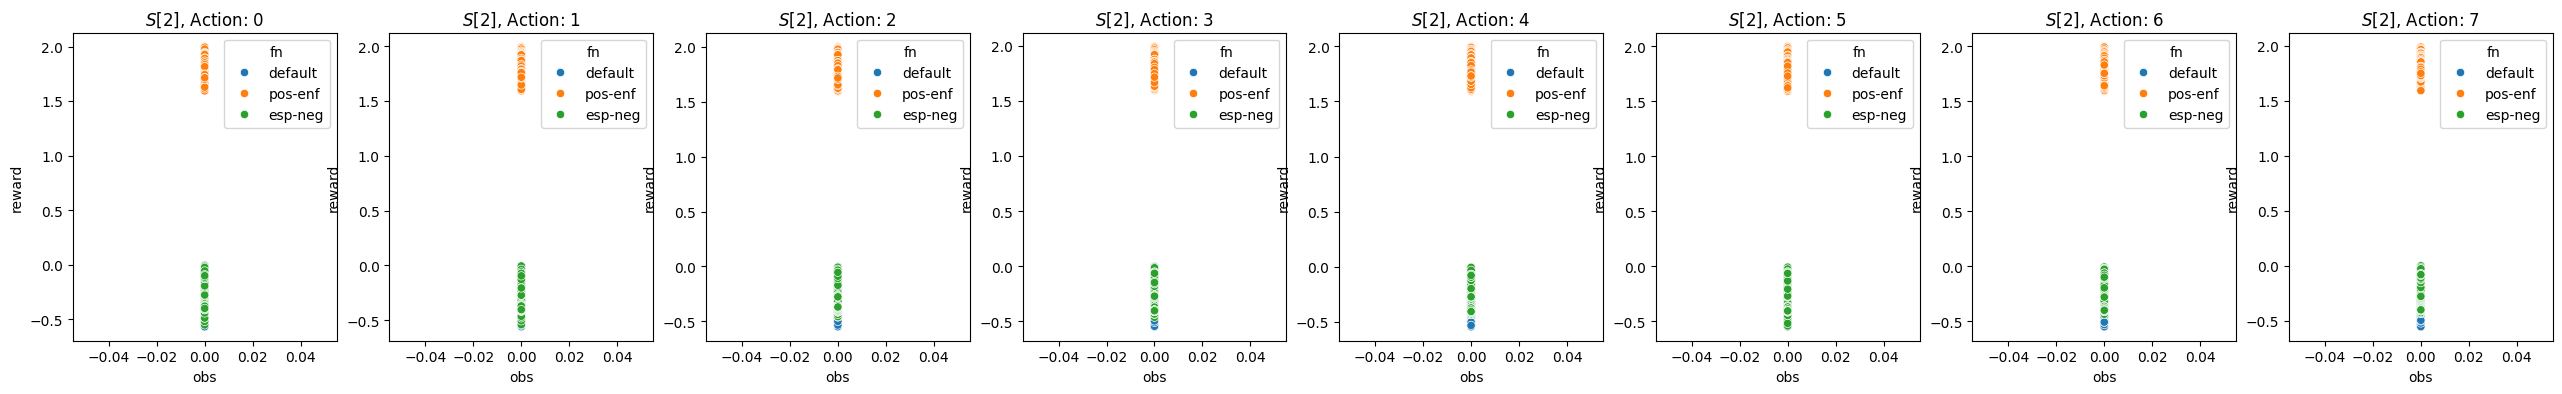

In [31]:
plot_rewards(df_obs_rew, state_idx=2)

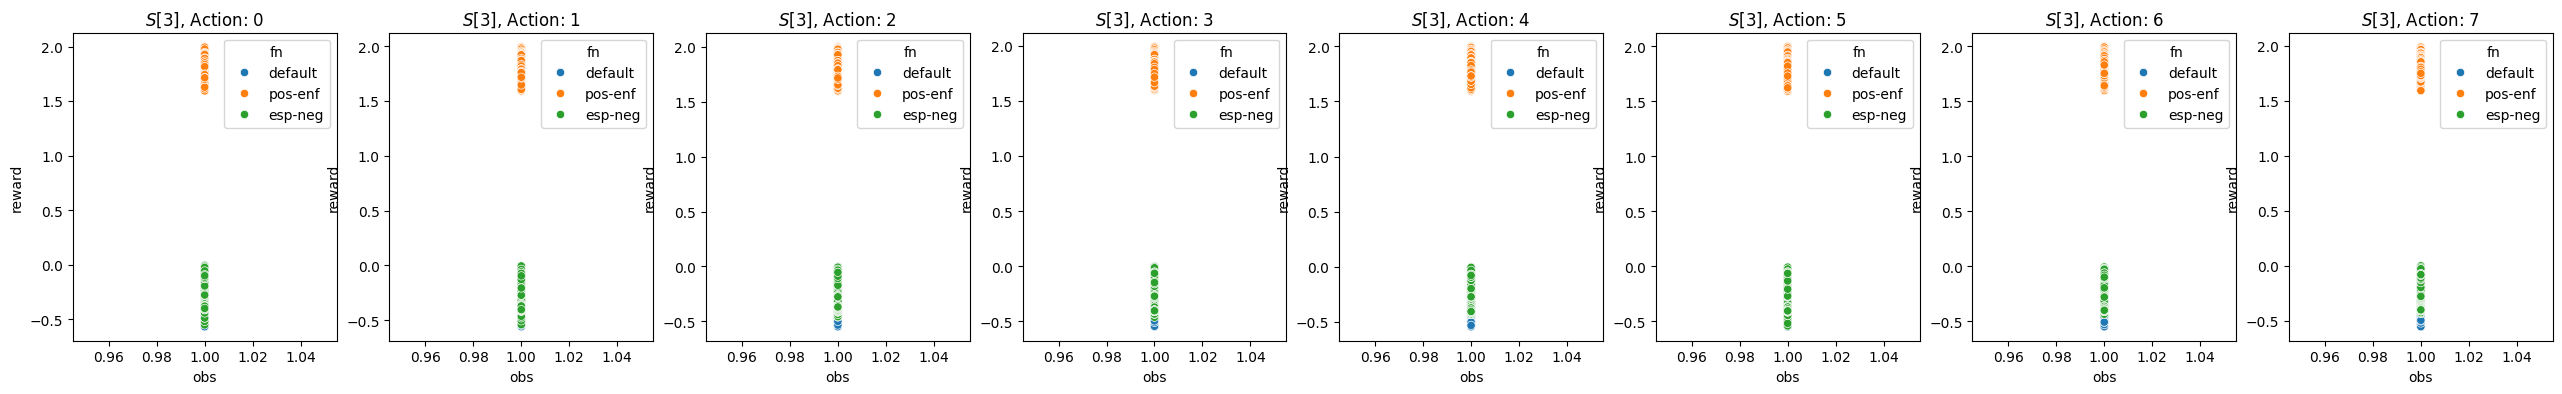

In [32]:
plot_rewards(df_obs_rew, state_idx=3)

## State $\Delta$ ~ Reward

In [33]:
def plot_state_change_rewards(df, state_idx):
    # remove extremes for pos
    df_plot = copy.deepcopy(df)
    df_plot = df_plot[np.abs(df["reward"].values) < (2**30 - 1)]
    actions = tuple(sorted(df_plot["action"].unique()))
    fig, axes = plt.subplots(ncols=len(actions), figsize=(4*len(actions), 4))
    for action, ax in zip(actions, axes.flatten()):
        df_subplot = df_plot[df_plot["action"] == action]
        df_subplot = copy.deepcopy(df_subplot[["obs", "next_obs", "reward", "fn"]])
        obs = df_subplot["obs"].apply(lambda xs: xs[state_idx])
        next_obs = df_subplot["next_obs"].apply(lambda xs: xs[state_idx])
        df_subplot["state_delta"] = next_obs - obs
        sns.scatterplot(data=df_subplot, x="state_delta", y="reward", hue="fn", ax=ax)
        ax.set_title(f"$S[{state_idx}]$, Action: {action}")

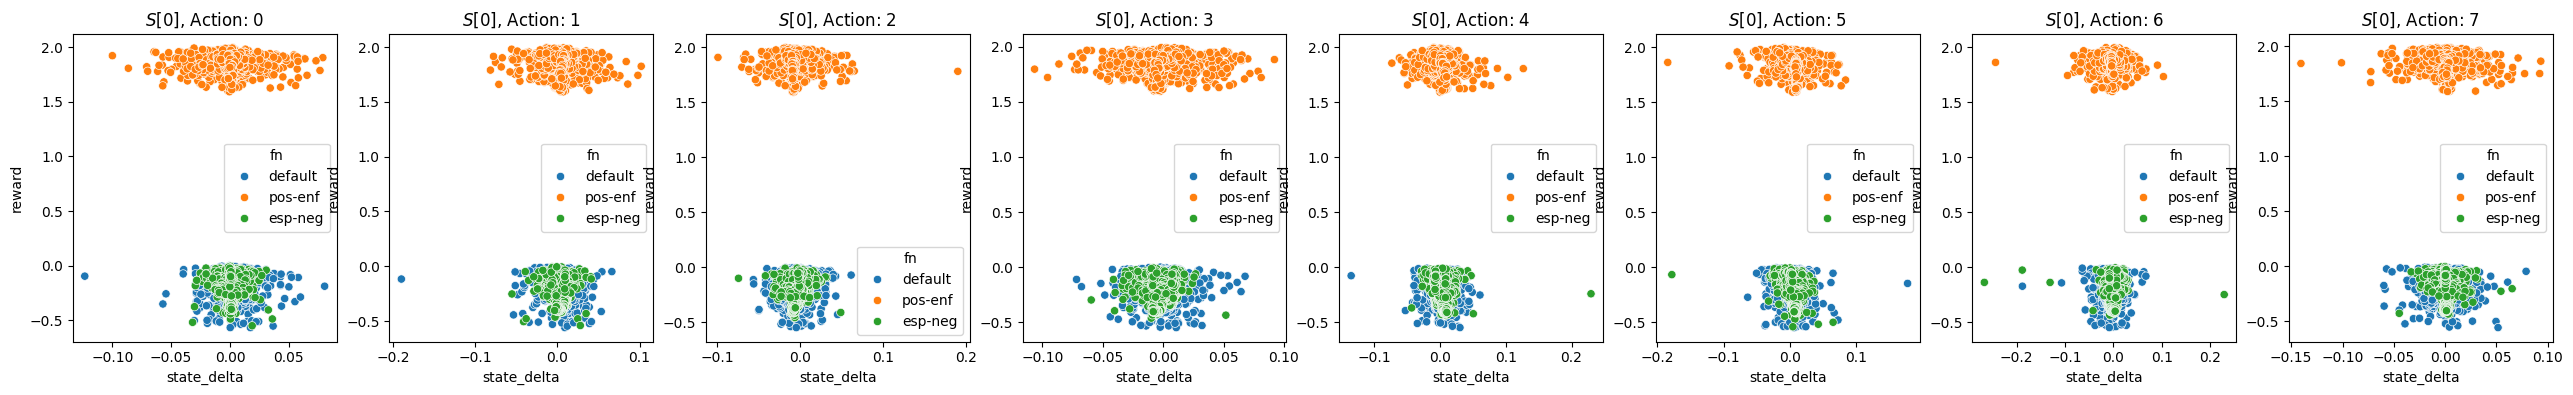

In [34]:
plot_state_change_rewards(df_obs_rew, state_idx=0)

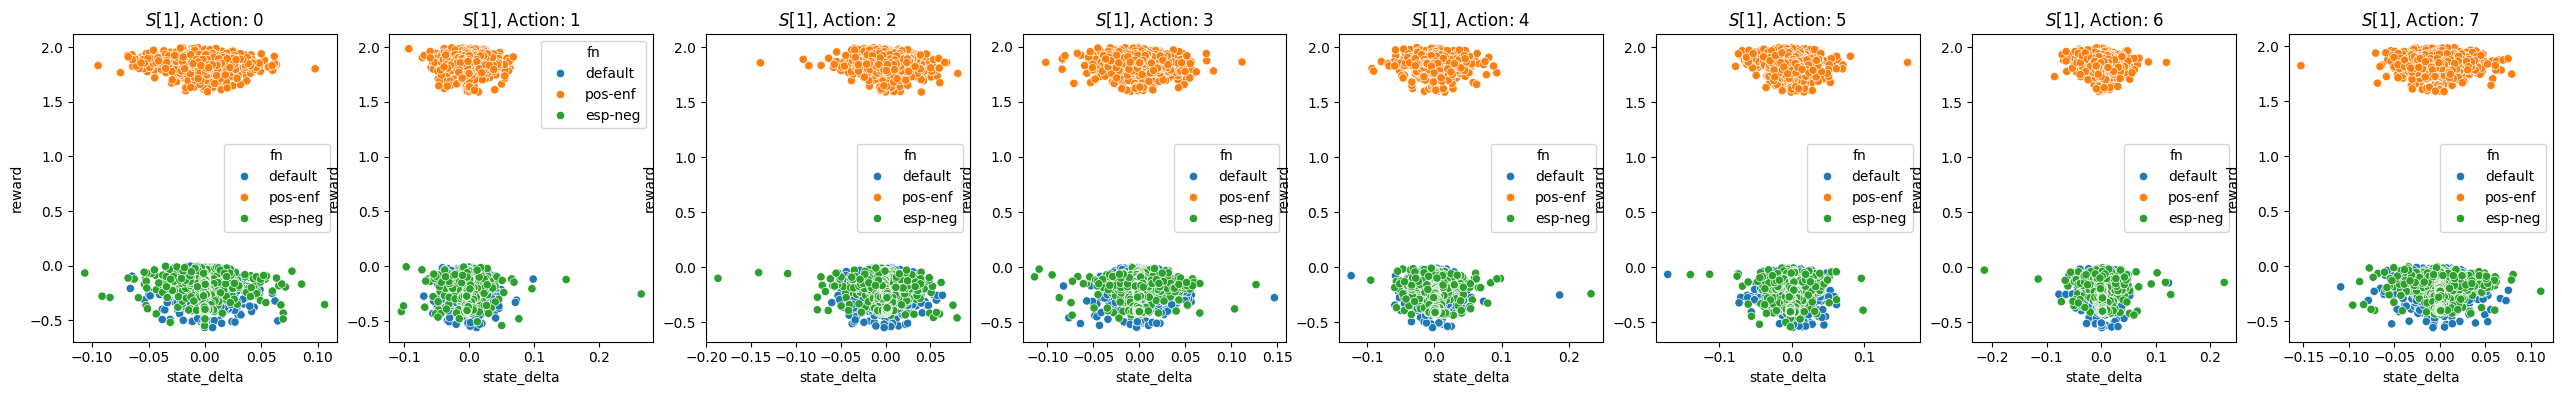

In [35]:
plot_state_change_rewards(df_obs_rew, state_idx=1)

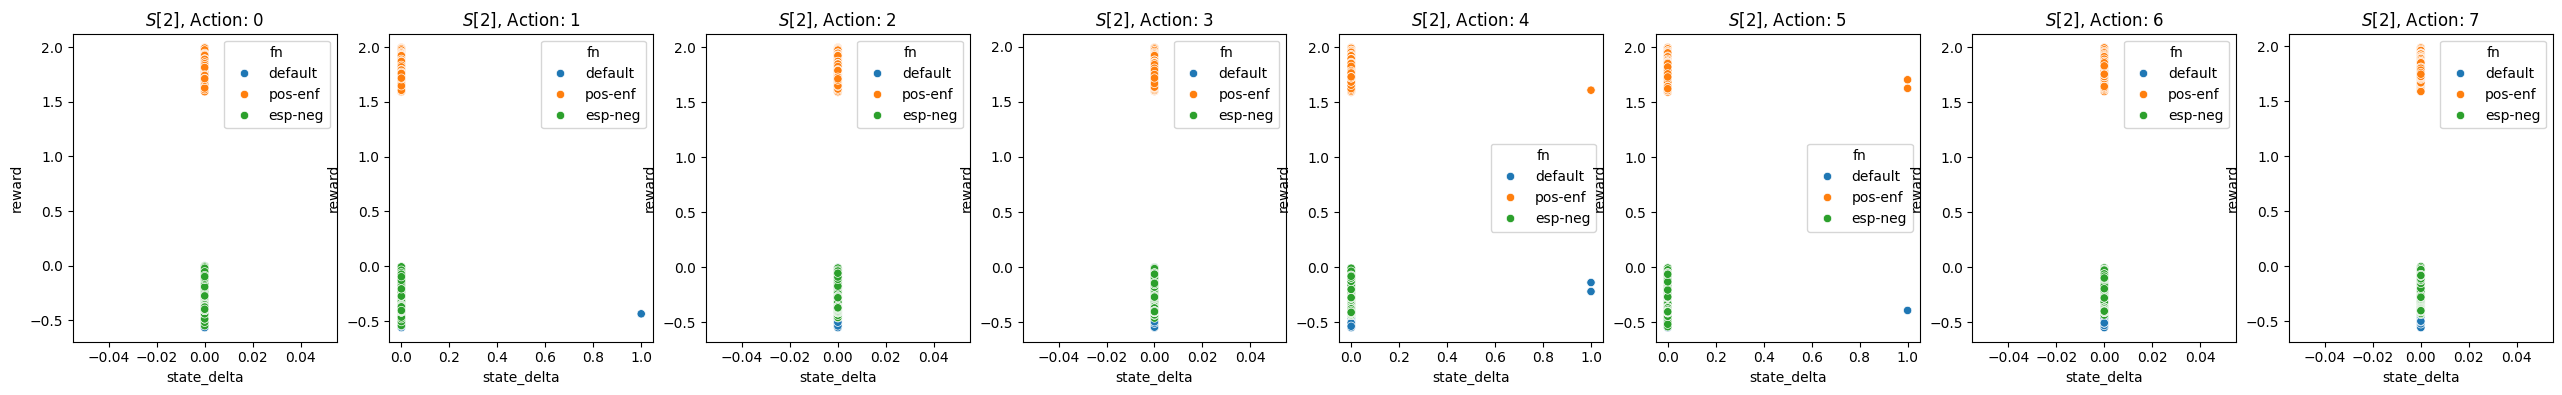

In [36]:
plot_state_change_rewards(df_obs_rew, state_idx=2)

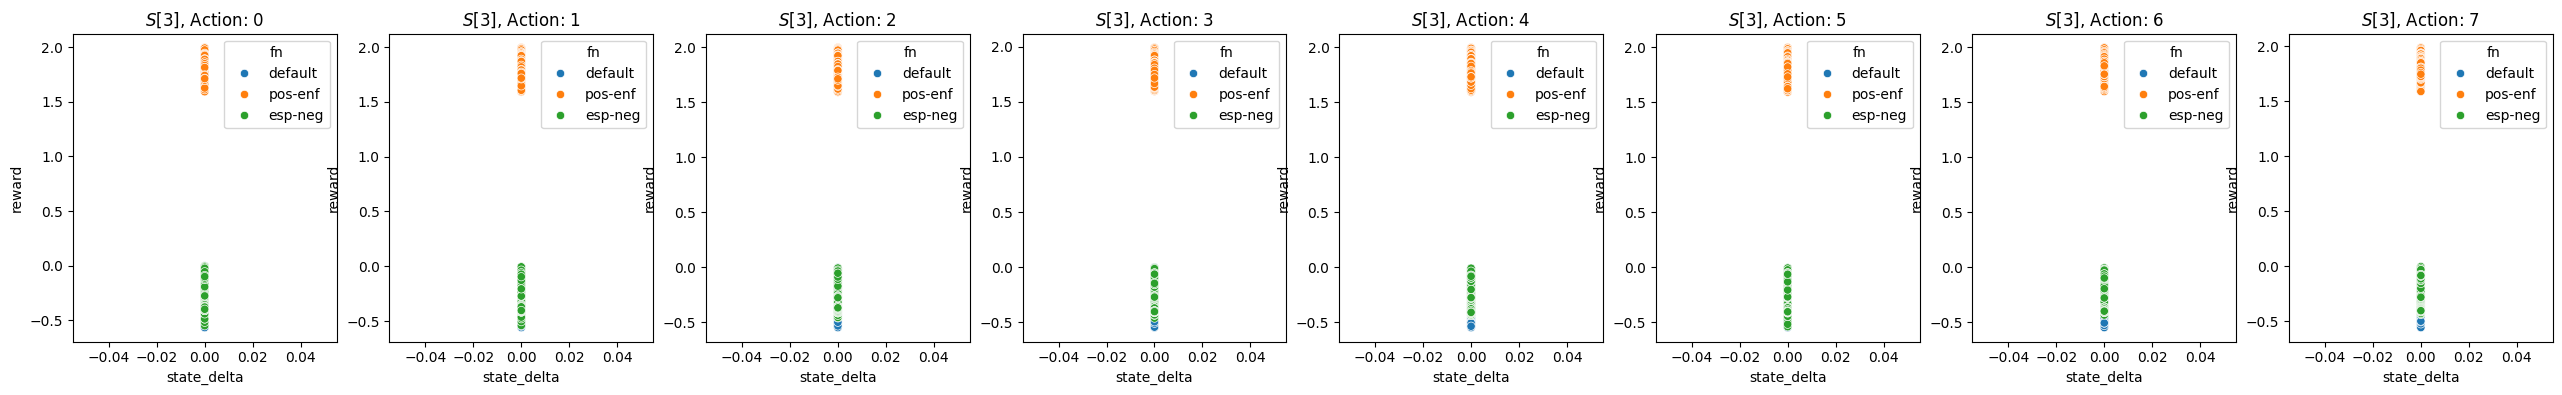

In [37]:
plot_state_change_rewards(df_obs_rew, state_idx=3)